# 2024-02-29 webinar Respect the pump, Intraday crypto seasonality COPY BTC
- video https://robotwealth.com/rw-pro-webinar-2024-02-29-respecting-the-pump/
- blog post https://robotwealth.com/rw-pro-weekly-update-1-march-2024-respect-the-pump-intraday-crypto-seasonality-constant-maturity-futures/
- notebook https://github.com/RWLab/crypto-pod/blob/main/research/intraday_seasonal_patterns.ipynb

The big idea:

- at any point a bunch of non-random trading is happening
- some of it probably has some daily regularity ("fund starts twapping every day at a certain hour")

So I was interested in: "Do the recent returns during some time of the day, explain future returns at that time?"

i.e. if SOL performed best at 1 UTC over the last 30 days, is it more likely to keep performing best in that hour tomorrow?

In [1]:
# install.packages("devtools")
# install.packages("pacman")

Installing package into ‘/usr/lib64/R/library’
(as ‘lib’ is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = TRUE)

options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tibbletime)
library(roll)
library(patchwork)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter




## Load Crypto Data

In [3]:
Sys.setenv(TZ = 'UTC')
Sys.timezone()
rwlab_data_auth()

[1] "UTC"

Authorization successful!

In [4]:
# attr(df$DateTime, "tzone") <- "UTC"
# load binance prices
raw_prices <- rwRtools::crypto_get_binance_spot_1h()

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 914 Mb )





File successfully transferred


In [4]:
# # filter last BTCUSDT data rows to compare with other data sources
# raw_prices %>%
#   filter(Ticker == "BTCUSDT") %>%
#   tail()

## Remove Stables, Wrapped Coins

In [84]:
# remove LUNAUSDT from Friday 13 May 2022. Even though it continued to exist after this, there's no way you'd include it in your universe of tradable assets.
prices <- raw_prices %>%
  # filter(Ticker == "ETHUSDT")
  filter(Ticker == "BTCUSDT")

# raw_prices %>% head

## Add Delta Column, rename others

In [5]:
# prices <- prices %>%
prices <- raw_prices %>%
  rename(
      ticker = Ticker,
      datetime = Datetime,
      open = Open,
      high = High,
      low = Low,
      close = Close,
      volume = Volume,
      quote_volume = `Quote asset volume`,
      num_trades = `Number of trades`,
      ask = `Taker buy base asset volume`,
      # bid = volume - ask,
      # delta = ask - bid
  ) %>%
  mutate (
      bid = volume - ask,
      delta = ask - bid,
  ) %>%
  select ( -`Taker buy quote asset volume`)
  
# prices %>% filter(ticker == "BTCUSDT") %>% tail()

In [6]:
csv_prices <- prices
csv_prices$datetime <- format(csv_prices$datetime, format = "%Y-%m-%d %H:%M:%S")
write.csv(csv_prices, "/notebook/universe.csv")

## Features analysis
- https://robotwealth.com/quantifying-and-combining-crypto-alphas/

### Set Returns

In [78]:
returns <- prices %>%
  arrange(datetime) %>%
  mutate(
    hour = lubridate::hour(datetime),
    # trail_volatility = roll::roll_sd(returns, 7*24) * sqrt(365),
    # vol_adjusted_returns = returns * (0.5 / lag(trail_volatility)), # 7 day trailing vol to size things by
    # returns
    simple_return = (close / lag(close) - 1),
    log_return = log(close / lag(close)),
    future_simple_return = (lead(close) / close - 1),
    future_log_return = log(lead(close) / close),
  ) %>%
  na.omit()
# returns %>% head()

### Define Breakout, Momo, Rate Features

In [79]:

rolling_periods_since_high_72 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      periods_since_high <- length(x) - idx_of_high
      periods_since_high
    },
    window = 72, na_value = NA),
  otherwise = NA
)

# Function to scale the periods since high into a range from -9.5 to 9.5
scale_periods_since_high <- function(periods_since_high, total_periods) {
  # Calculate which decile the period falls into (1 to 10)
  decile <- findInterval(periods_since_high, seq(0, total_periods, length.out = 11), rightmost.closed = TRUE)
  # Scale from 1-10 to -9.5 to 9.5
  scaled_value <- decile - 5.5
  return(scaled_value)
}
rolling_periods_since_high <- function(close_prices, window_size) {
  purrr::possibly(
    tibbletime::rollify(
      function(x) {
        idx_of_high <- which.max(x)
        periods_since_high <- length(x) - idx_of_high
        # Call the scaling function to transform periods_since_high to a range from -9.5 to 9.5
        scale_periods_since_high(periods_since_high, length(x))
      },
      window = window_size, 
      na_value = NA
    ),
    otherwise = NA
  )(close_prices)
}

features <- returns %>%
  # group_by(datetime) %>%
  arrange(datetime) %>%
  mutate(
    # we won't lag features here because we're using forward returns
    # breakout = 71.5 - rolling_hours_since_high_72(close),  # puts this feature on a scale -9.5 to +9.5 (9.5 = high was today)
    breakout = rolling_periods_since_high_72(close),  # puts this feature on a scale -9.5 to +9.5 (9.5 = high was today)
    # breakout = rolling_periods_since_high(close, 92),
    momo = (close - lag(close, 10)) / lag(close, 10), # standard momentum calculation is usually the percentage change over a period
    rate = close - lag(close, 10)/close
  ) %>%
  ungroup() %>%
  na.omit()

head(features)

ticker,datetime,open,high,low,close,volume,quote_volume,num_trades,ask,bid,delta,hour,simple_return,log_return,future_simple_return,future_log_return,breakout,momo,rate
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>


In [80]:
features %>%
  pivot_longer(c(breakout, momo, rate, delta), names_to = "feature") %>%
  ggplot(aes(x = value, colour = feature)) +
  geom_density() +
  facet_wrap(~feature, scales = "free")

ERROR while rich displaying an object: Error in `combine_vars()`:
! Faceting variables must have at least one value.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. pa

### Scale Features to Zscores and Deciles

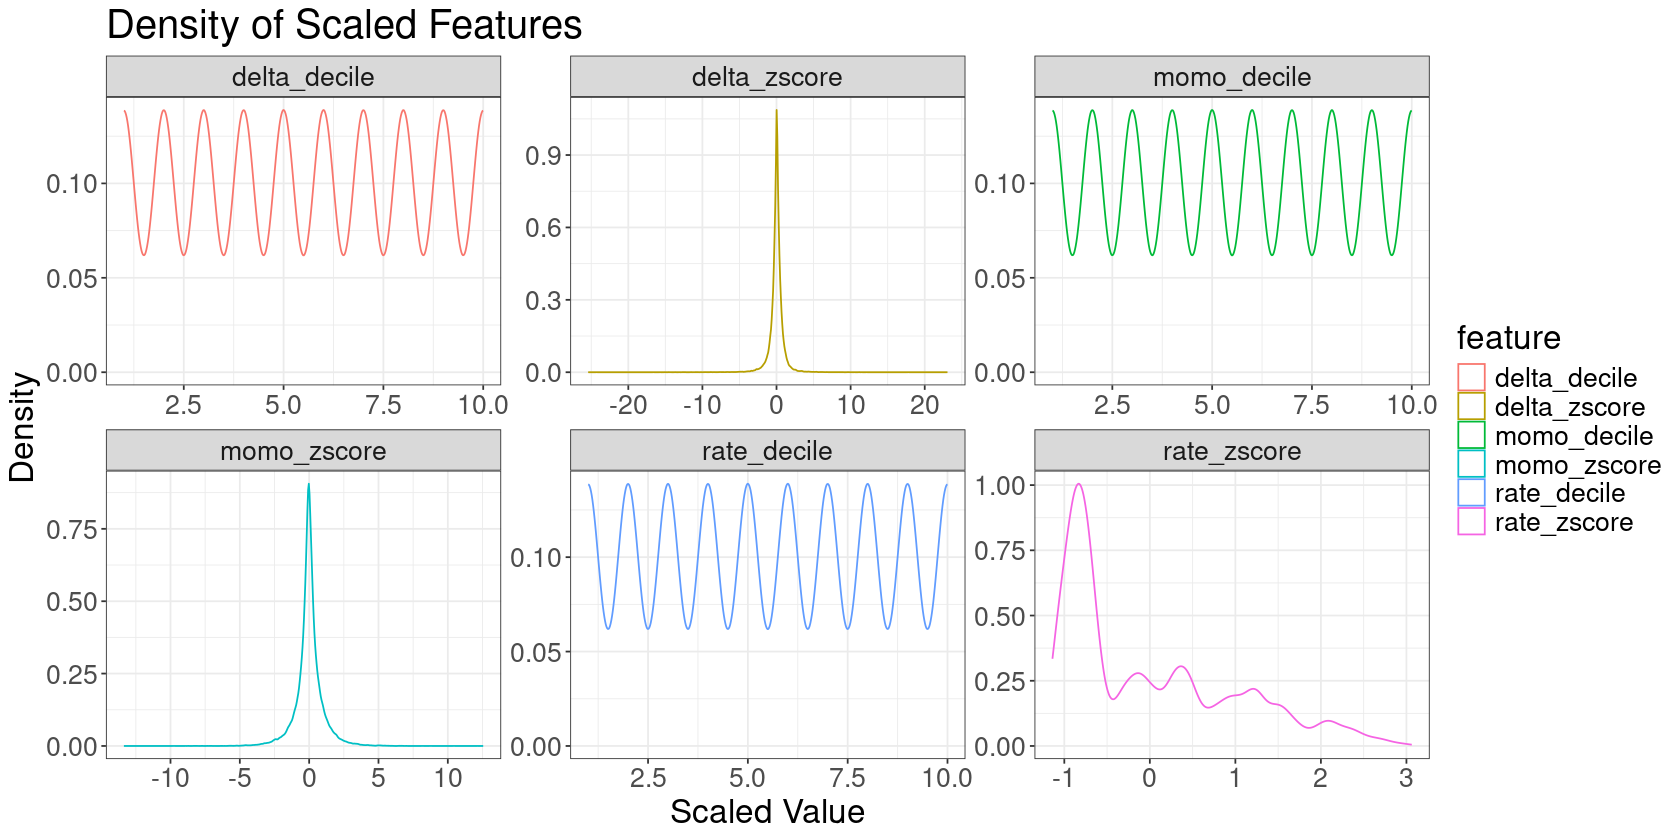

In [56]:
features_scaled <- features %>%
  mutate(
    # demeaned_future_simple_returns = future_simple_return - mean(future_simple_return),
    # zscores
    delta_zscore = (delta - mean(delta, na.rm = TRUE)) / sd(delta, na.rm = TRUE),
    momo_zscore = (momo - mean(momo, na.rm = TRUE)) / sd(momo, na.rm = TRUE),
    rate_zscore = (rate - mean(rate, na.rm = TRUE)) / sd(rate, na.rm = TRUE),
    # # Decile scaling
    # delta_decile = 5.5 - ntile(delta, 10), # scaling to values from -4.5 to 4.5
    # momo_decile = 5.5 - ntile(momo, 10), # scaling to values from -4.5 to 4.5
    # rate_decile = 5.5 - ntile(rate, 10), # scaling to values from -4.5 to 4.5
    # only positive
    delta_decile = ntile(delta, 10), # scaling to values from -4.5 to 4.5
    momo_decile = ntile(momo, 10), # scaling to values from -4.5 to 4.5
    rate_decile = ntile(rate, 10), # scaling to values from -4.5 to 4.5
  ) %>%
  na.omit() %>%
  ungroup()

# features_scaled %>%
#   pivot_longer(c("delta_zscore", "momo_zscore", "rate_zscore", "delta_decile", "momo_decile", "rate_decile"), names_to = "feature") %>%
#   ggplot(aes(x = value, colour = feature)) +
#   geom_density() +
#   facet_wrap(~feature, scales = "free") 
features_scaled %>%
  pivot_longer(c("delta_zscore", "momo_zscore", "rate_zscore", "delta_decile", "momo_decile", "rate_decile"), names_to = "feature") %>%
  ggplot(aes(x = value, colour = feature)) +
  geom_density() +
  facet_wrap(~feature, scales = "free") +
  labs(title = "Density of Scaled Features", x = "Scaled Value", y = "Density")

### delta_decile

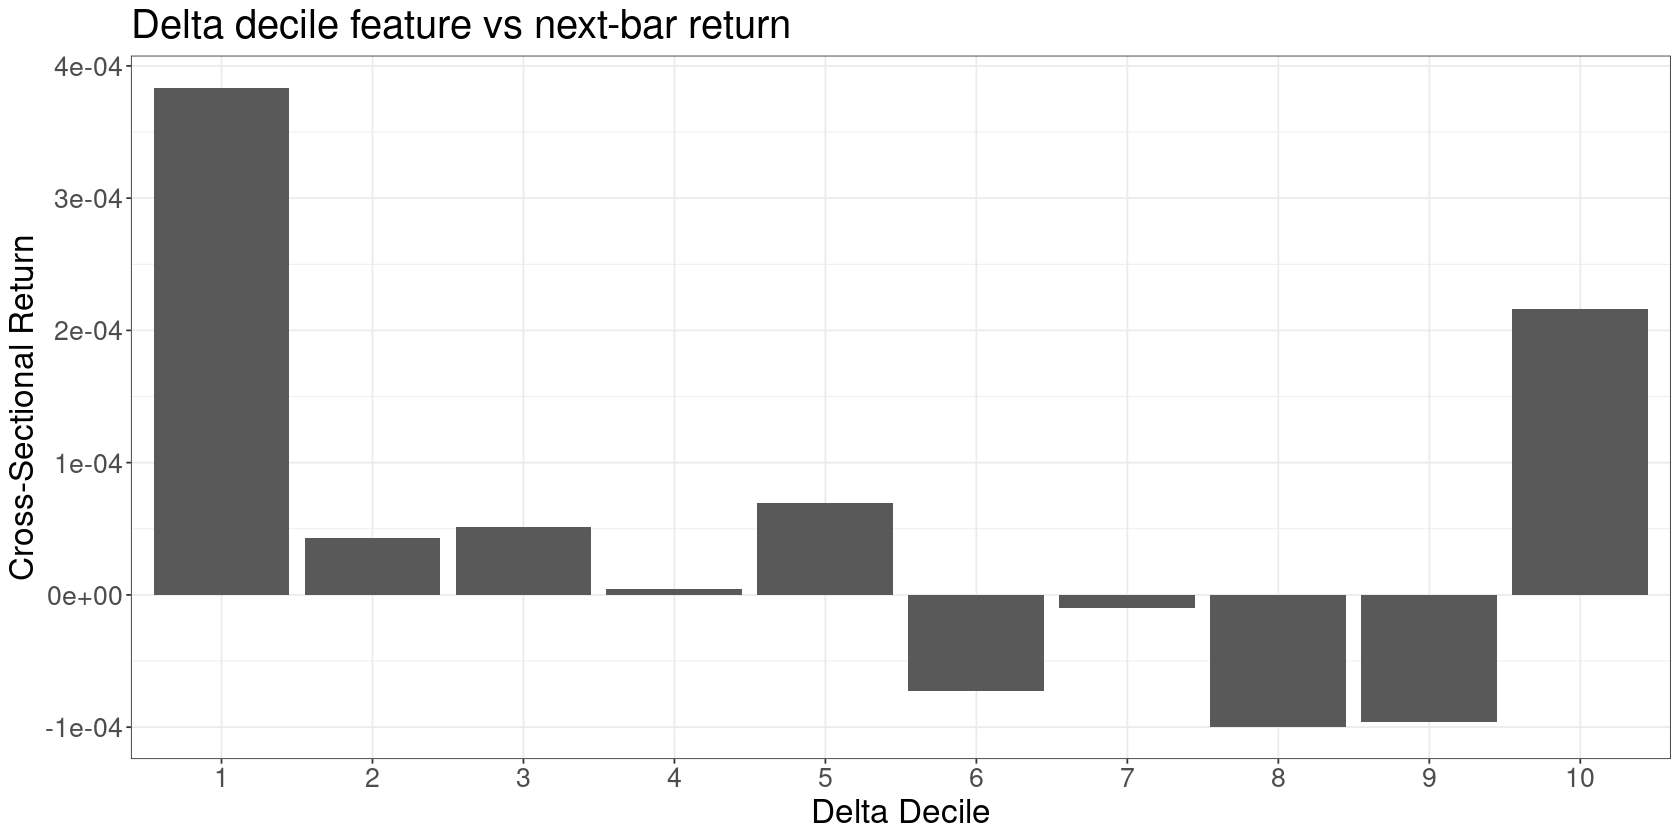

In [57]:
features_scaled %>%
  group_by(delta_decile) %>%
  summarise(
    # mean_return = mean(mean(demeaned_future_simple_returns))
    mean_return = mean(future_log_return)
  ) %>%
  ggplot(aes(x = factor(delta_decile), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Delta Decile",
    y = "Cross-Sectional Return",
    title = "Delta decile feature vs next-bar return"
  )


### momo_decile

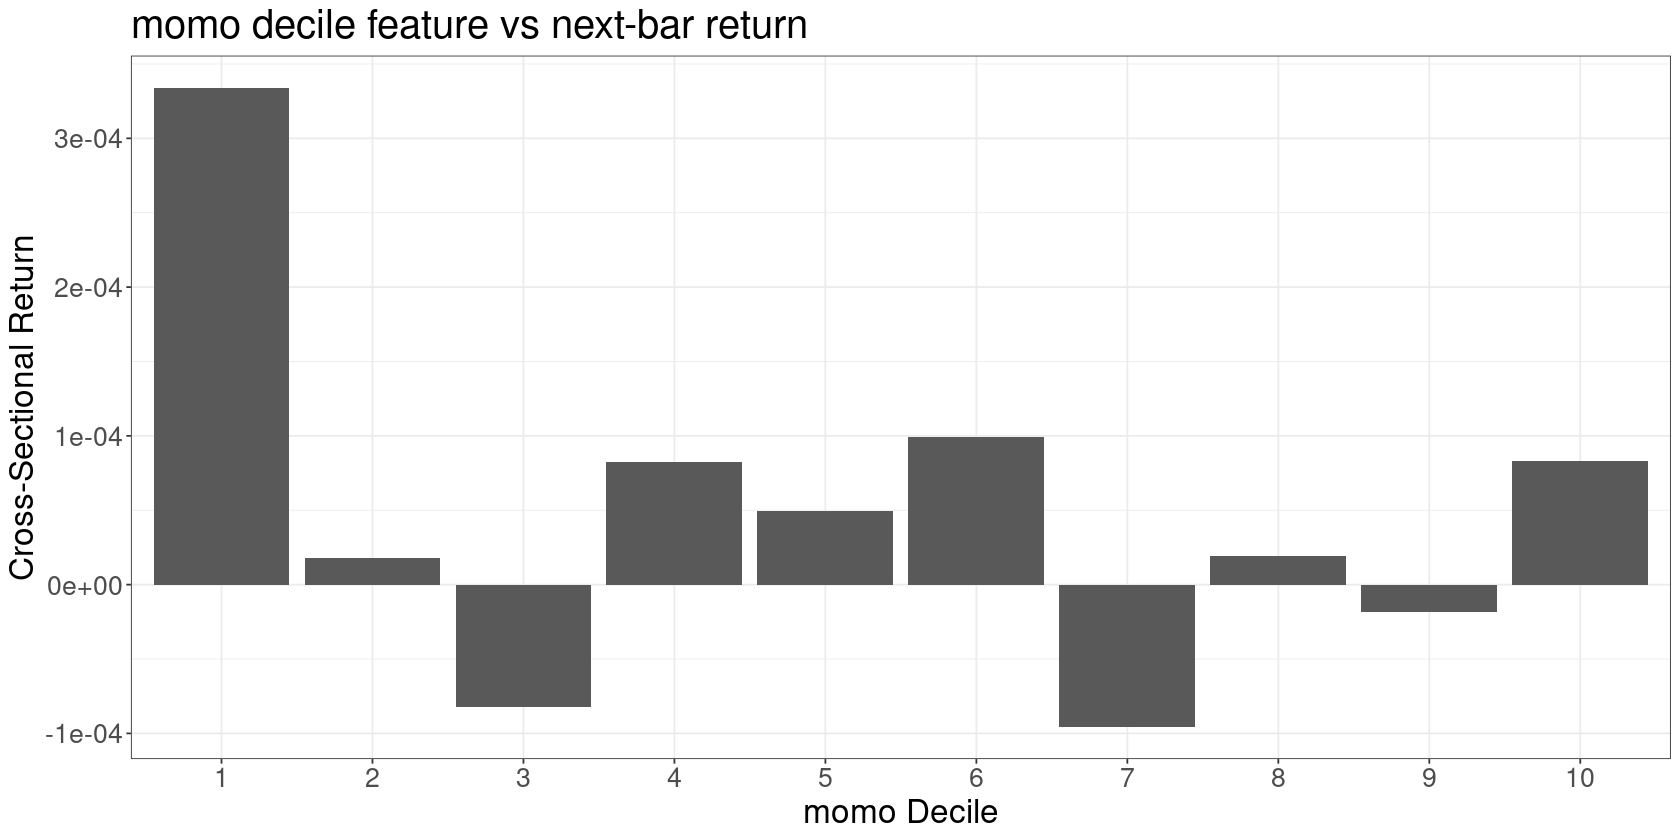

In [58]:
features_scaled %>%
  group_by(momo_decile) %>%
  summarise(
    mean_return = mean(future_log_return)
  ) %>%
  ggplot(aes(x = factor(momo_decile), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "momo Decile",
    y = "Cross-Sectional Return",
    title = "momo decile feature vs next-bar return"
  )

### Rate Decile

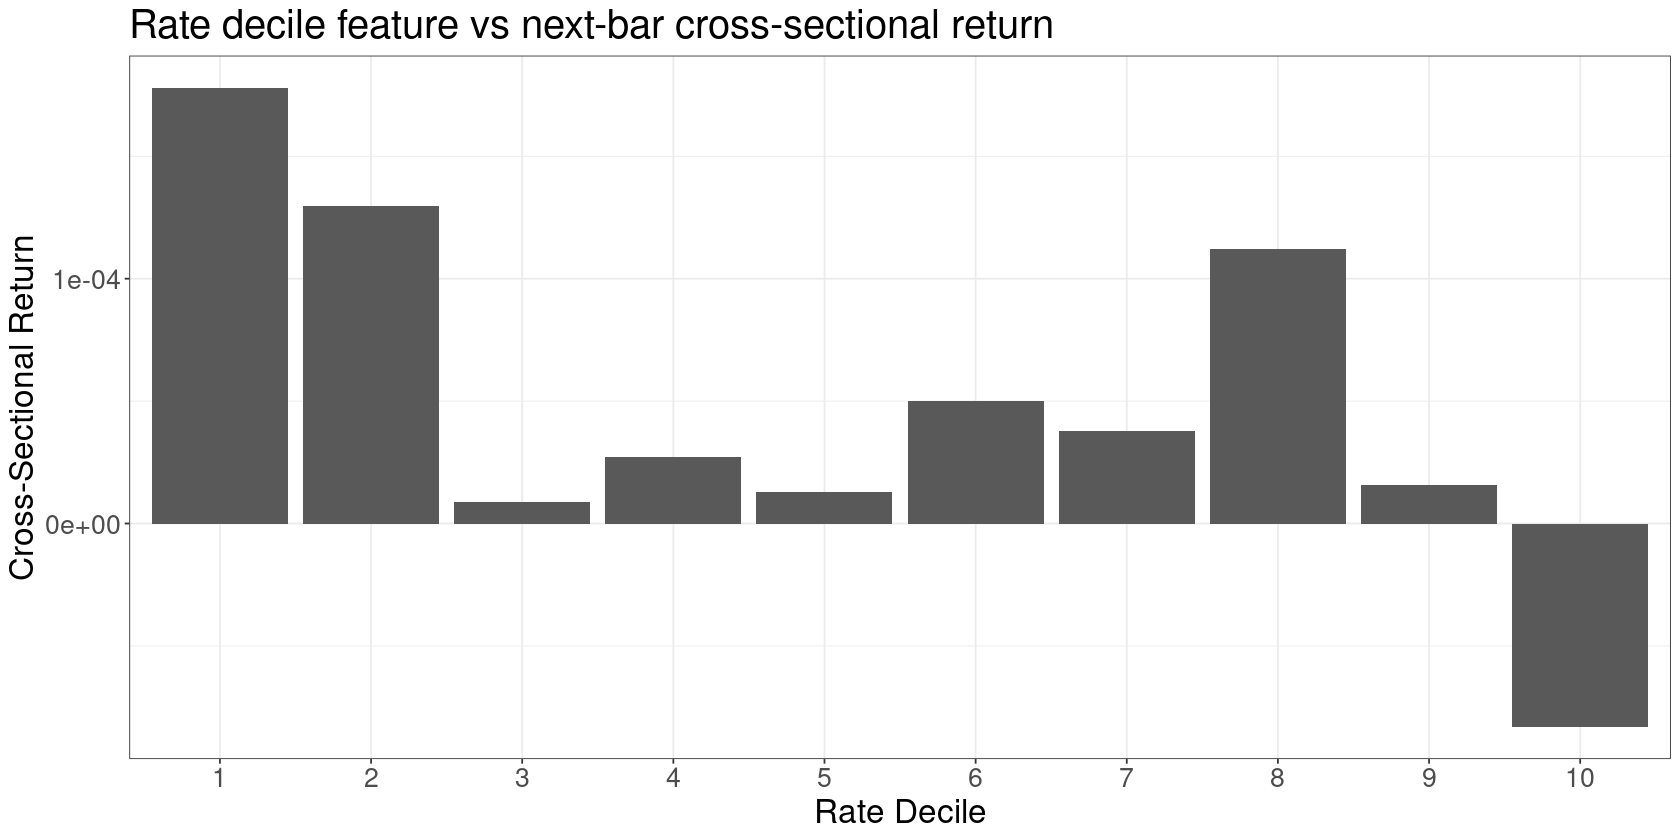

In [59]:
features_scaled %>%
  # filter(ticker == "SOL") %>%
  group_by(rate_decile) %>%
  summarise(
    mean_return = mean(future_log_return)
    # mean_return = mean(mean(demeaned_future_simple_returns))
  ) %>%
  ggplot(aes(x = factor(rate_decile), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Rate Decile",
    y = "Cross-Sectional Return",
    title = "Rate decile feature vs next-bar cross-sectional return"
  )

### breakout

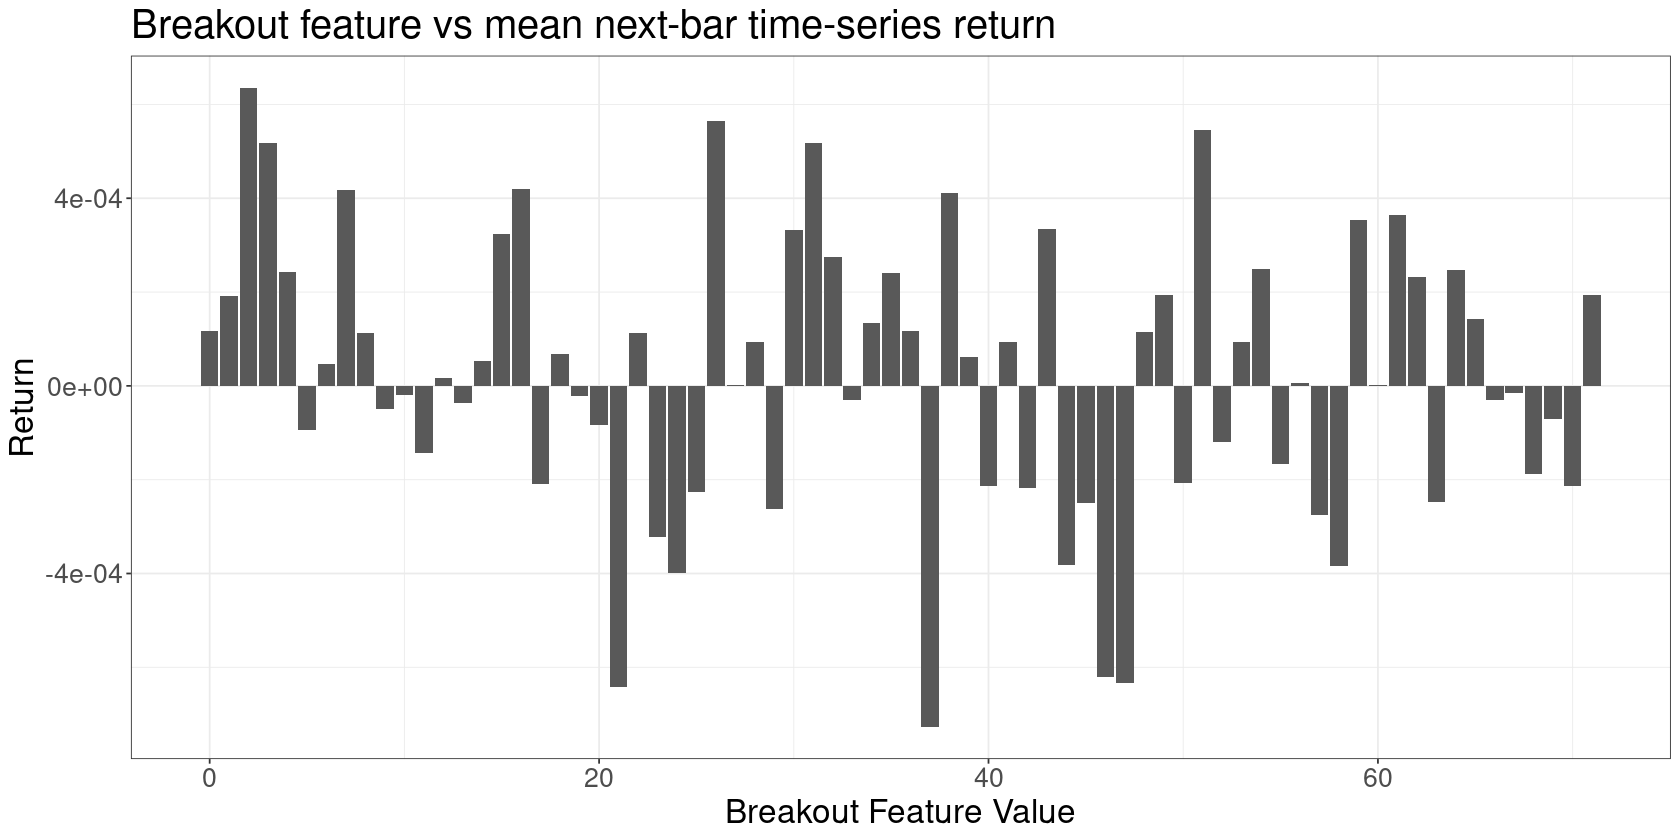

In [60]:
features_scaled %>%
  group_by(breakout) %>%
  summarise(
    mean_return = mean(future_log_return)
  ) %>%
  ggplot(aes(x = breakout, y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Breakout Feature Value",
    y = "Return",
    title = "Breakout feature vs mean next-bar time-series return"
  )

### Information coefficient
The information coefficient is simply the correlation of the feature with next day returns. It provides a single metric for quantifying the strength of the signal. We can calculate it for time-series returns and cross-sectional returns:

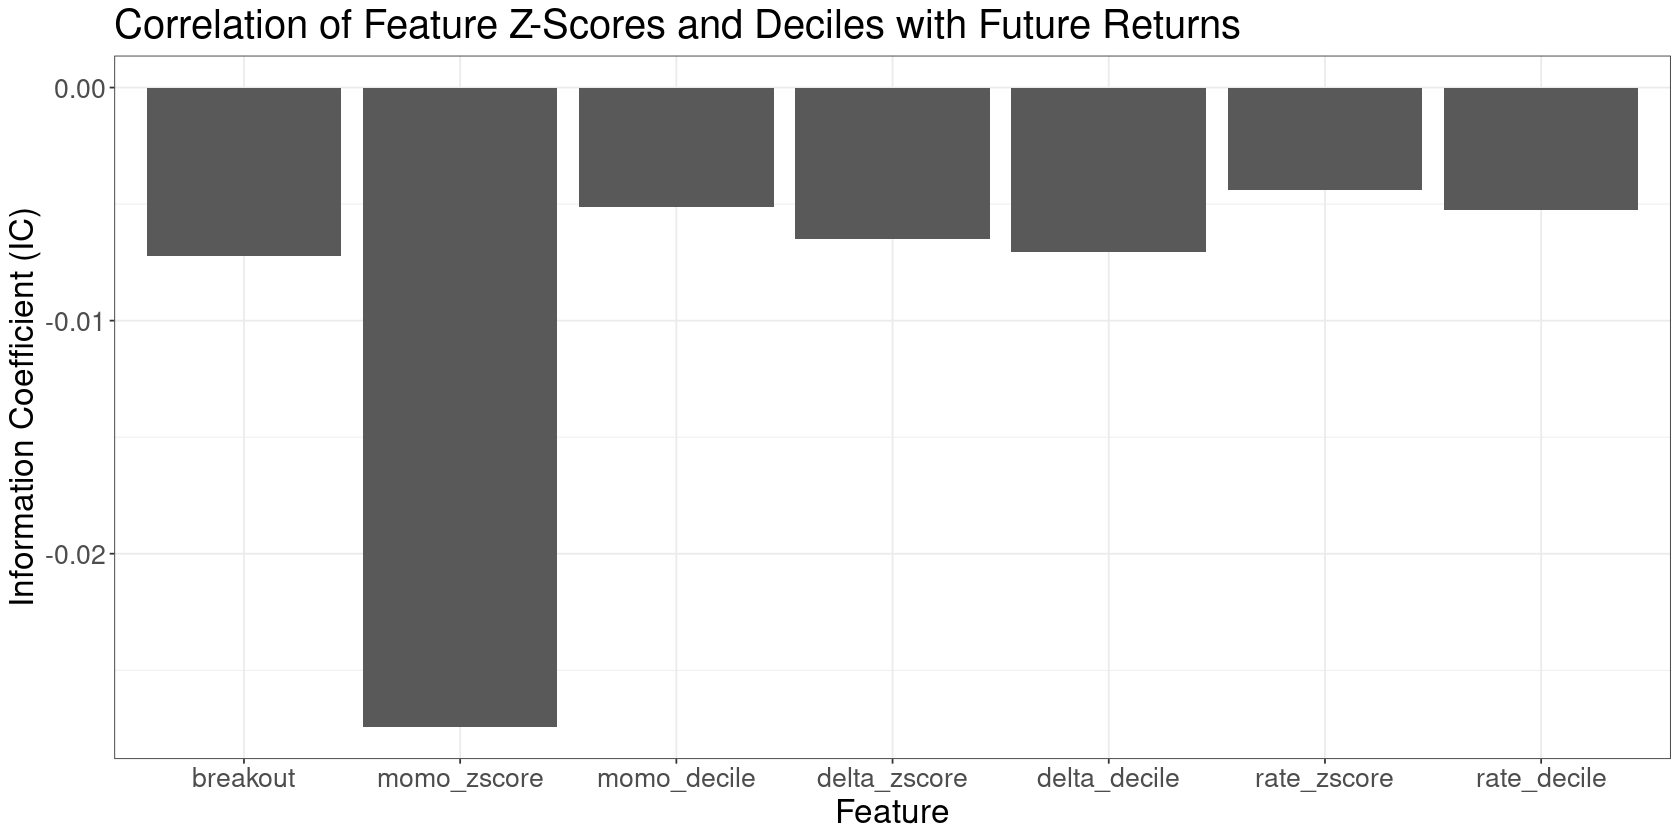

In [61]:
features_scaled %>%
  # pivot_longer(c(momo_decile), names_to = "feature") %>%
  pivot_longer(c(breakout, 
                 momo_zscore, momo_decile, 
                 delta_zscore, delta_decile, 
                 rate_zscore, rate_decile), names_to = "feature") %>%
  group_by(feature) %>%
  summarize(IC = cor(value, future_log_return))  %>%
  ggplot(aes(x = factor(feature, levels = 
    c('breakout', 
      'momo_zscore', 'momo_decile', 
      'delta_zscore', 'delta_decile', 
      'rate_zscore', 'rate_decile')), y = IC)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Correlation of Feature Z-Scores and Deciles with Future Returns",
    y = "Information Coefficient (IC)",
    x = "Feature"
  )

### Decay characteristics

Next, it’s useful to understand how quickly your signals decay. Signals that decay quickly need to be acted upon without delay, while those that decay slower are more forgiving to execute.

We’ll look at relative return IC for our cross-sectional features and the time-series return IC for our breakout feature.


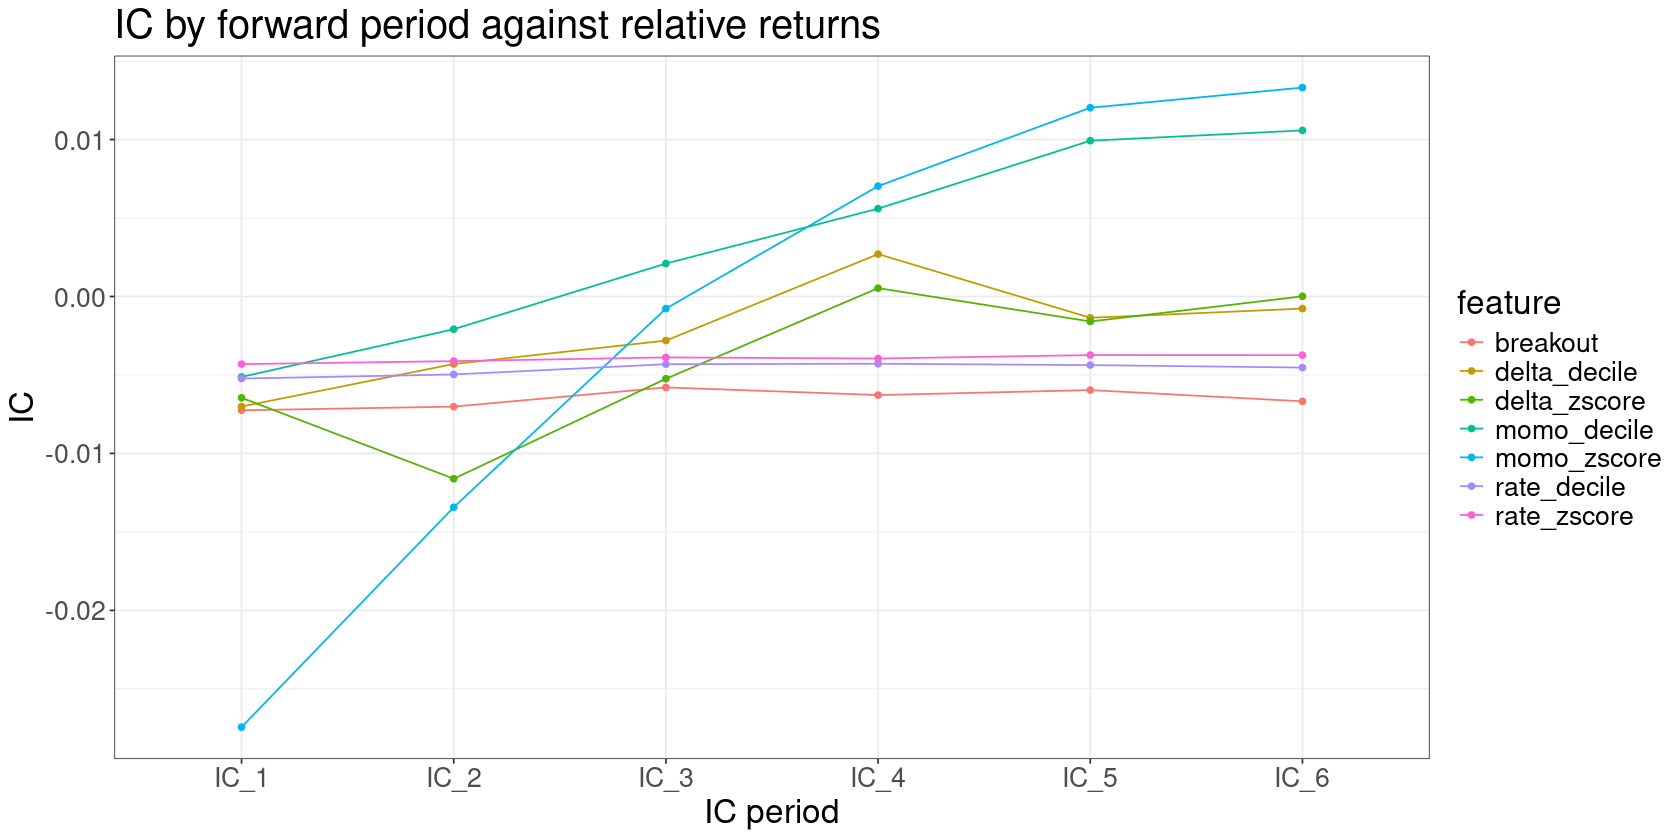

In [62]:
features_scaled %>%
  arrange(datetime) %>%
  mutate(
    future_log_return_2 = lead(future_log_return, 1),
    future_log_return_3 = lead(future_log_return, 2),
    future_log_return_4 = lead(future_log_return, 3),
    future_log_return_5 = lead(future_log_return, 4),
    future_log_return_6 = lead(future_log_return, 5),
  ) %>%
  na.omit() %>%
  ungroup() %>%
  pivot_longer(c(breakout, 
                 momo_zscore, momo_decile, 
                 delta_zscore, delta_decile, 
                 rate_zscore, rate_decile), names_to = "feature") %>%
  # pivot_longer(c(breakout, momo_zscore, momo_decile, delta_zscore, delta_decile), names_to = "feature") %>%
  # pivot_longer(c(zscore_carry, zscore_momo, decile_carry, decile_momo), names_to = "feature") %>%
  group_by(feature) %>%
  summarize(
    IC_1 = cor(value, future_log_return),
    IC_2 = cor(value, future_log_return_2),
    IC_3 = cor(value, future_log_return_3),
    IC_4 = cor(value, future_log_return_4),
    IC_5 = cor(value, future_log_return_5),
    IC_6 = cor(value, future_log_return_6),
  )  %>%
  pivot_longer(-feature, names_to = "IC_period", values_to = "IC") %>%
  ggplot(aes(x = factor(IC_period), y = IC, colour = feature, group = feature)) +
  geom_line() +
  geom_point() +
  labs(
    title = "IC by forward period against relative returns",
    x = "IC period"
  )

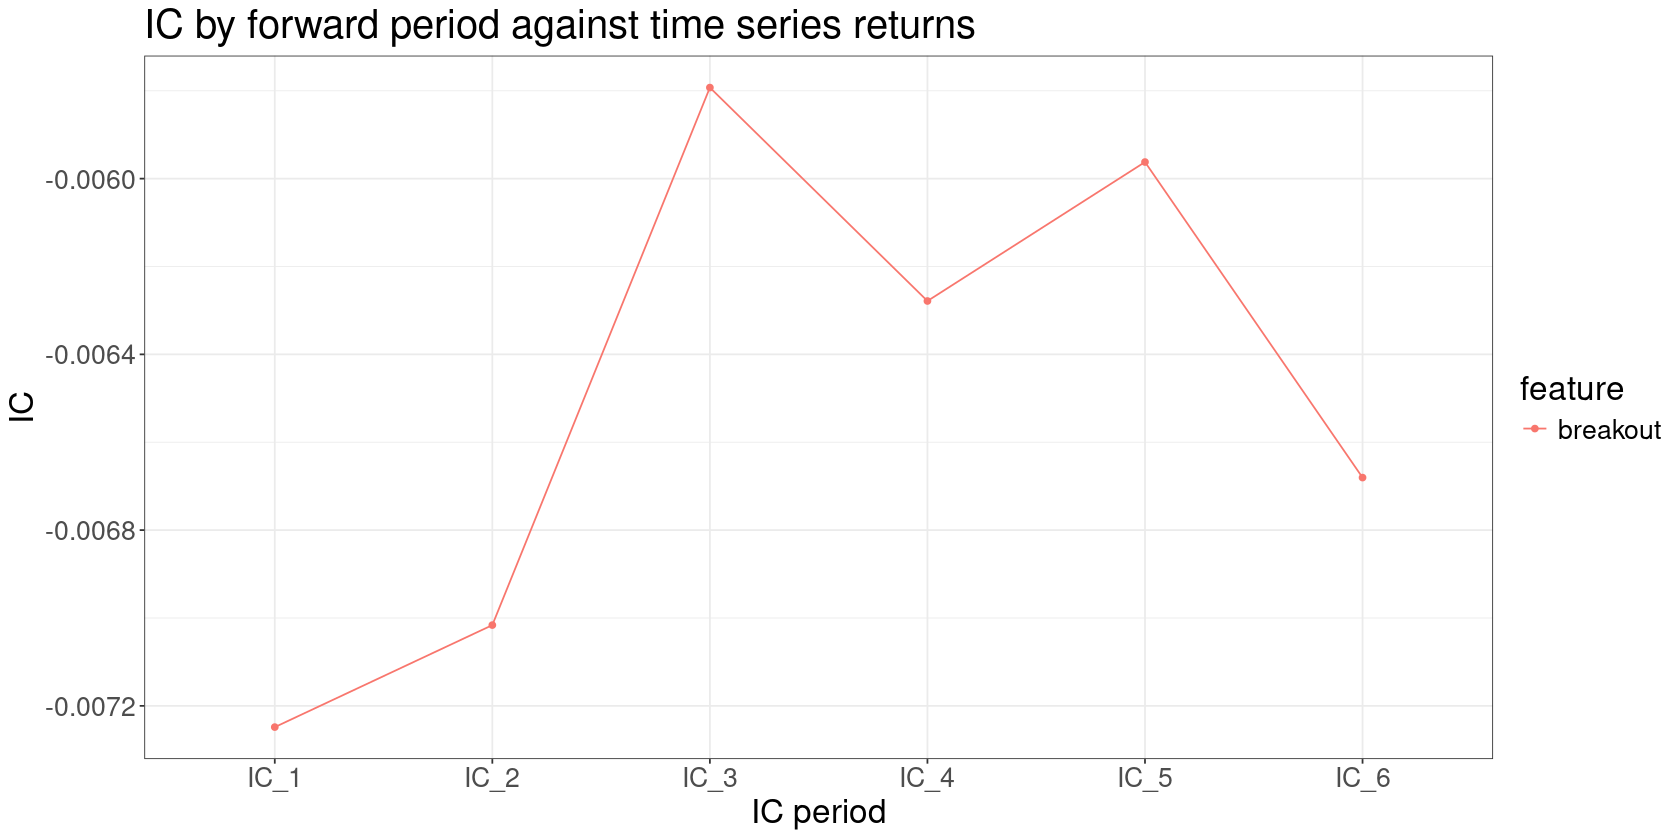

In [63]:
features_scaled %>%
  mutate(
    future_log_return_2 = lead(future_log_return, 1),
    future_log_return_3 = lead(future_log_return, 2),
    future_log_return_4 = lead(future_log_return, 3),
    future_log_return_5 = lead(future_log_return, 4),
    future_log_return_6 = lead(future_log_return, 5),
  ) %>%
  na.omit() %>%
  ungroup() %>%
  pivot_longer(c(breakout), names_to = "feature") %>%
  group_by(feature) %>%
  summarize(
    IC_1 = cor(value, future_log_return),
    IC_2 = cor(value, future_log_return_2),
    IC_3 = cor(value, future_log_return_3),
    IC_4 = cor(value, future_log_return_4),
    IC_5 = cor(value, future_log_return_5),
    IC_6 = cor(value, future_log_return_6),
  )  %>%
  pivot_longer(-feature, names_to = "IC_period", values_to = "IC") %>%
  ggplot(aes(x = factor(IC_period), y = IC, colour = feature, group = feature)) +
  geom_line() +
  geom_point() +
  labs(
    title = "IC by forward period against time series returns",
    x = "IC period"
  )

### Feature correlation

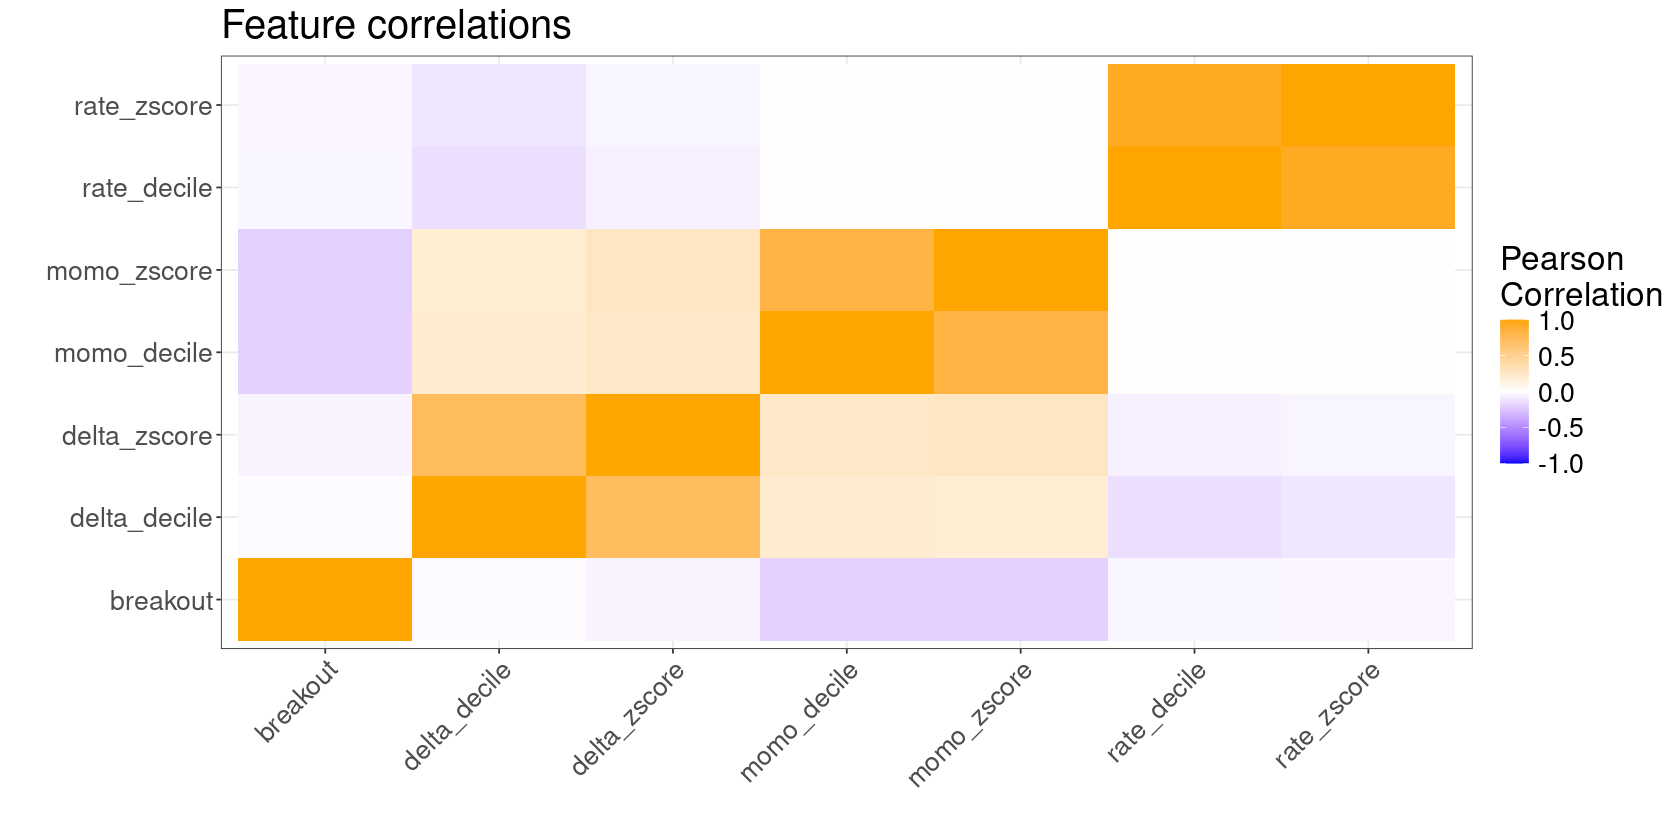

In [64]:
features_scaled %>%
  # ggplot(aes(x = factor(feature, levels = c('breakout', 'momo_zscore', 'momo_decile', 'delta_zscore', 'delta_decile')), y = IC)) +
  select('breakout', 
      'momo_zscore', 'momo_decile', 
      'delta_zscore', 'delta_decile', 
      'rate_zscore', 'rate_decile') %>%
  as.matrix() %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("feature1") %>%
  pivot_longer(-feature1, names_to = "feature2", values_to = "corr") %>%
  ggplot(aes(x = feature1 , y = feature2, fill = corr)) +
  geom_tile() +
  scale_fill_gradient2(
    low = "blue",
    high = "orange",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1),
    name="Pearson\nCorrelation"
  ) +
  labs(
    x = "",
    y = "",
    title = "Feature correlations"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 16, hjust = 1))

### Combining our signals

ticker,datetime,open,high,low,close,volume,quote_volume,num_trades,ask,⋯,rate_zscore,delta_decile,momo_decile,rate_decile,breakout_weight,combined_weight,scaled_weight,returns,logreturns,max_decile
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2017-08-20 04:00:00,4094.62,4094.62,4091.8,4093,0.809243,3313.402,37,0.809243,⋯,-1.068902,6,6,1,-31,-0.63,-0.63,-0.00375722,-0.003764296,-0.13


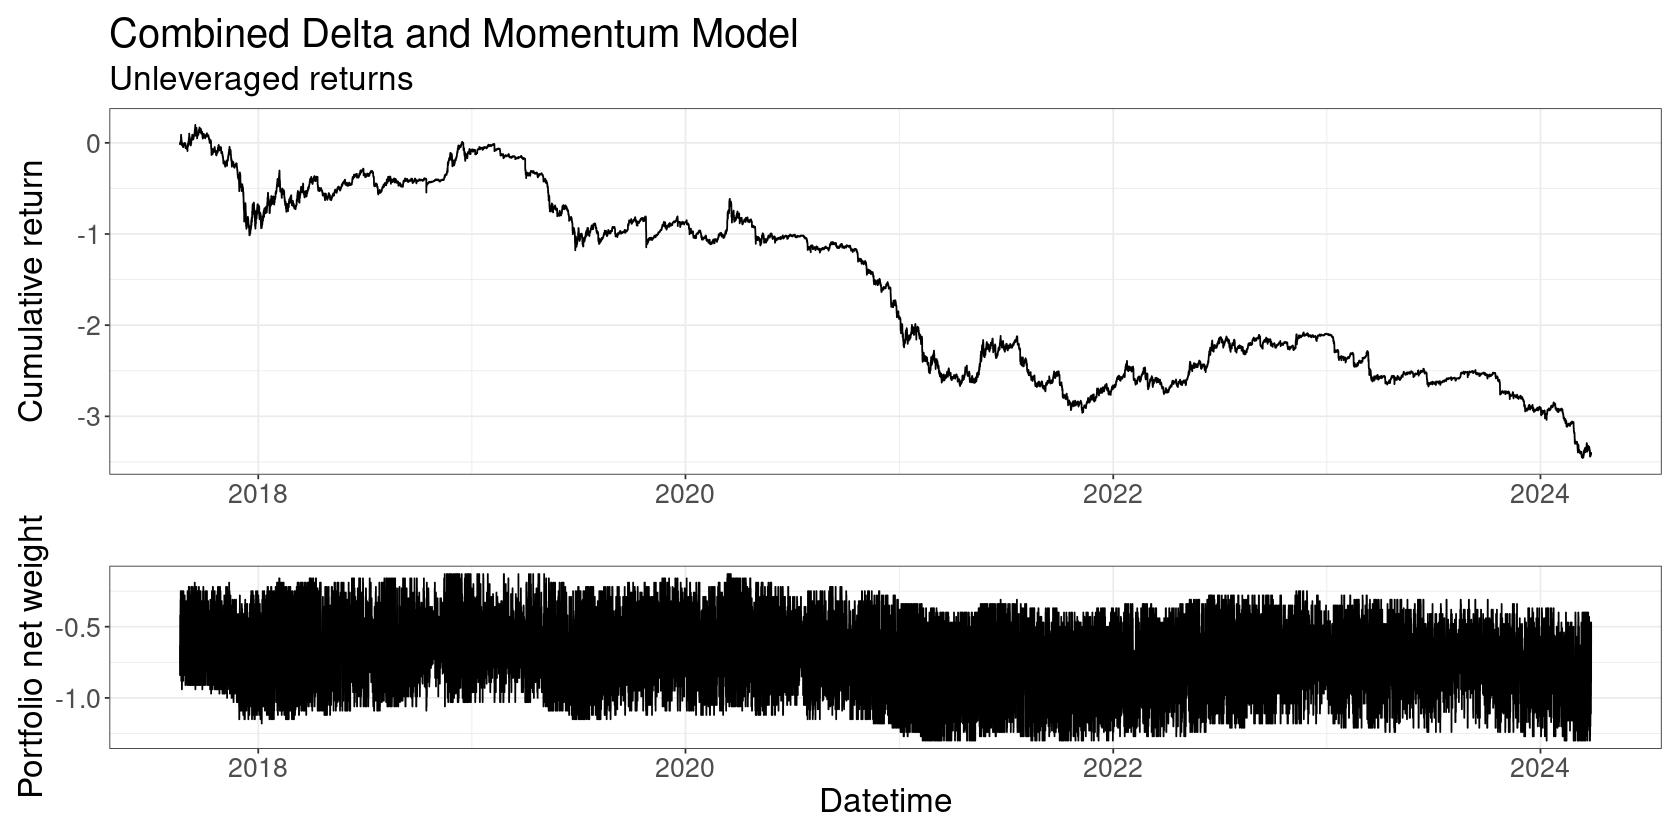

In [74]:
model_df <- features_scaled %>%
  mutate(
      breakout_weight = -breakout / 2,
      combined_weight = (-0.7*momo_decile + -0.3*delta_decile + -0.3*rate_decile)/10,
      # combined_weight = -(0.7*momo_decile + 0.3*delta_decile + 0.3*rate_decile)/10,
      # combined_weight = (0.5*momo_decile + 0.2*delta_decile + 0.2*rate_decile + 0.1*breakout),
      scaled_weight = combined_weight,
      returns = scaled_weight * future_simple_return,
      logreturns = log(returns+1),
  )
# head(model_df)
model_df %>%
  mutate(
      max_decile = max(combined_weight),
      ) %>%
head(1)
# # draw rerurns and cumsum of returns
# returns_plot <- model_df %>%
#   summarize(returns = scaled_weight * future_simple_return, .groups = "drop") %>%
#   mutate(logreturns = log(returns+1)) %>%
#   na.omit() 

# ggplot(returns_plot, aes(x=datetime, y=returns)) +
# # ggplot(returns_plot, aes(x=datetime, y=logreturns)) +
#   geom_line() 

# ggplot(returns_plot, aes(x=datetime, y=cumsum(returns))) +
# # ggplot(returns_plot, aes(x=datetime, y=cumsum(logreturns))) +
#   geom_line() 

returns_plot <- model_df %>%
  na.omit() %>% # this line must be hero for the chart to complete
  # ggplot(aes(x=datetime, y=cumsum(future_return))) +
  ggplot(aes(x=datetime, y=cumsum(logreturns))) +
  geom_line() +
  labs(
    title = 'Combined Delta and Momentum Model',
    subtitle = "Unleveraged returns",
    x = "",
    y = "Cumulative return"
  )
# returns_plot
weights_plot <- model_df %>%
  group_by(datetime) %>%
  summarise(total_weight = sum(scaled_weight)) %>%
  ggplot(aes(x = datetime, y = total_weight)) +
  geom_line() +
  labs(x = "Datetime", y = "Portfolio net weight")

returns_plot / weights_plot + plot_layout(heights = c(2,1))

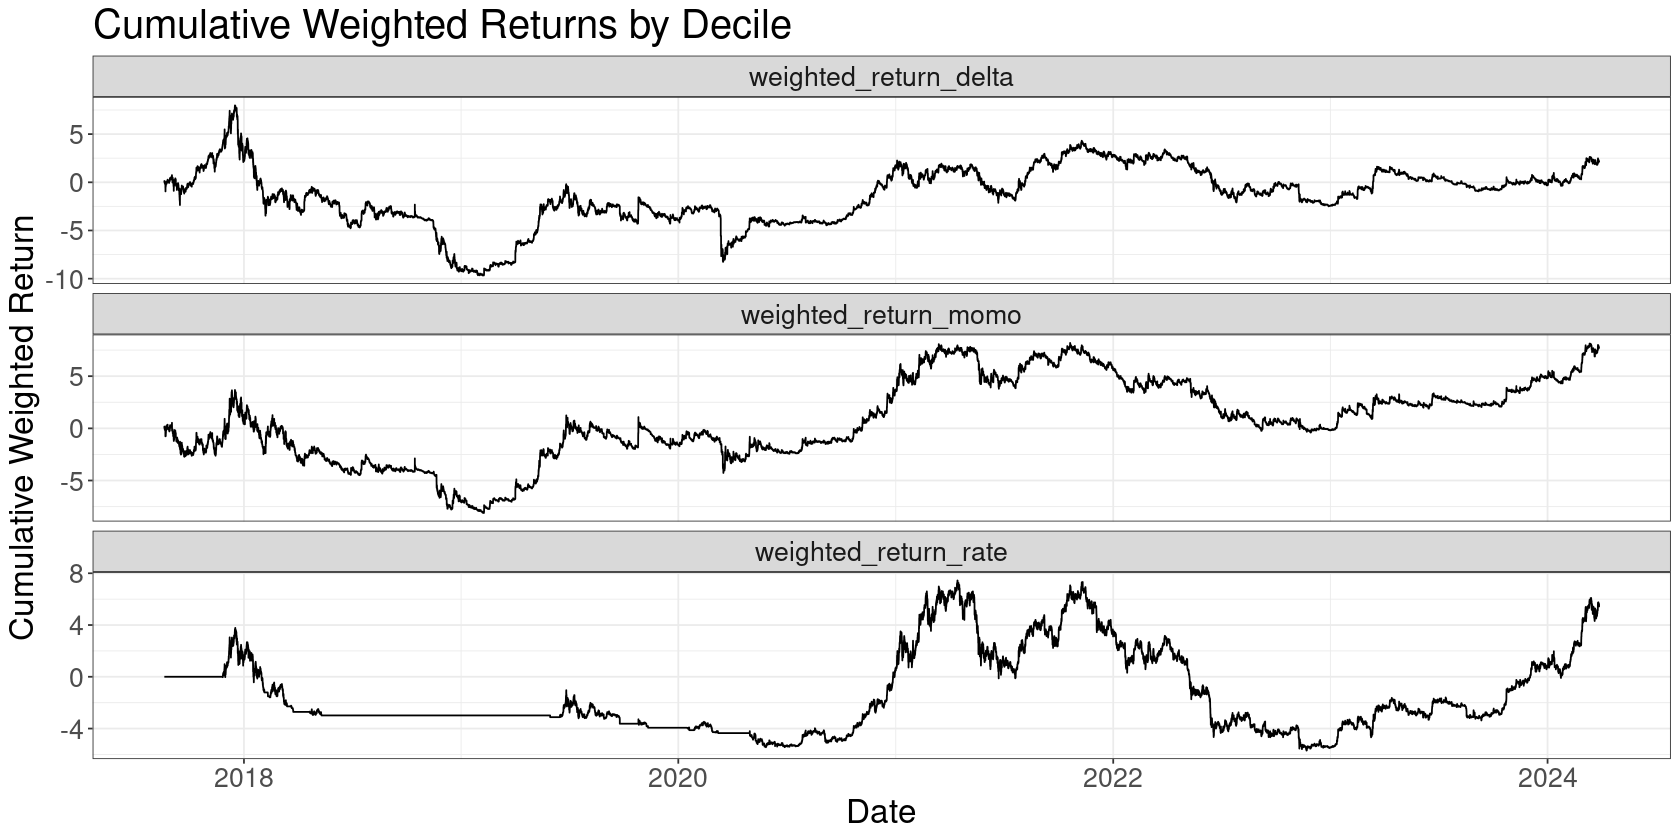

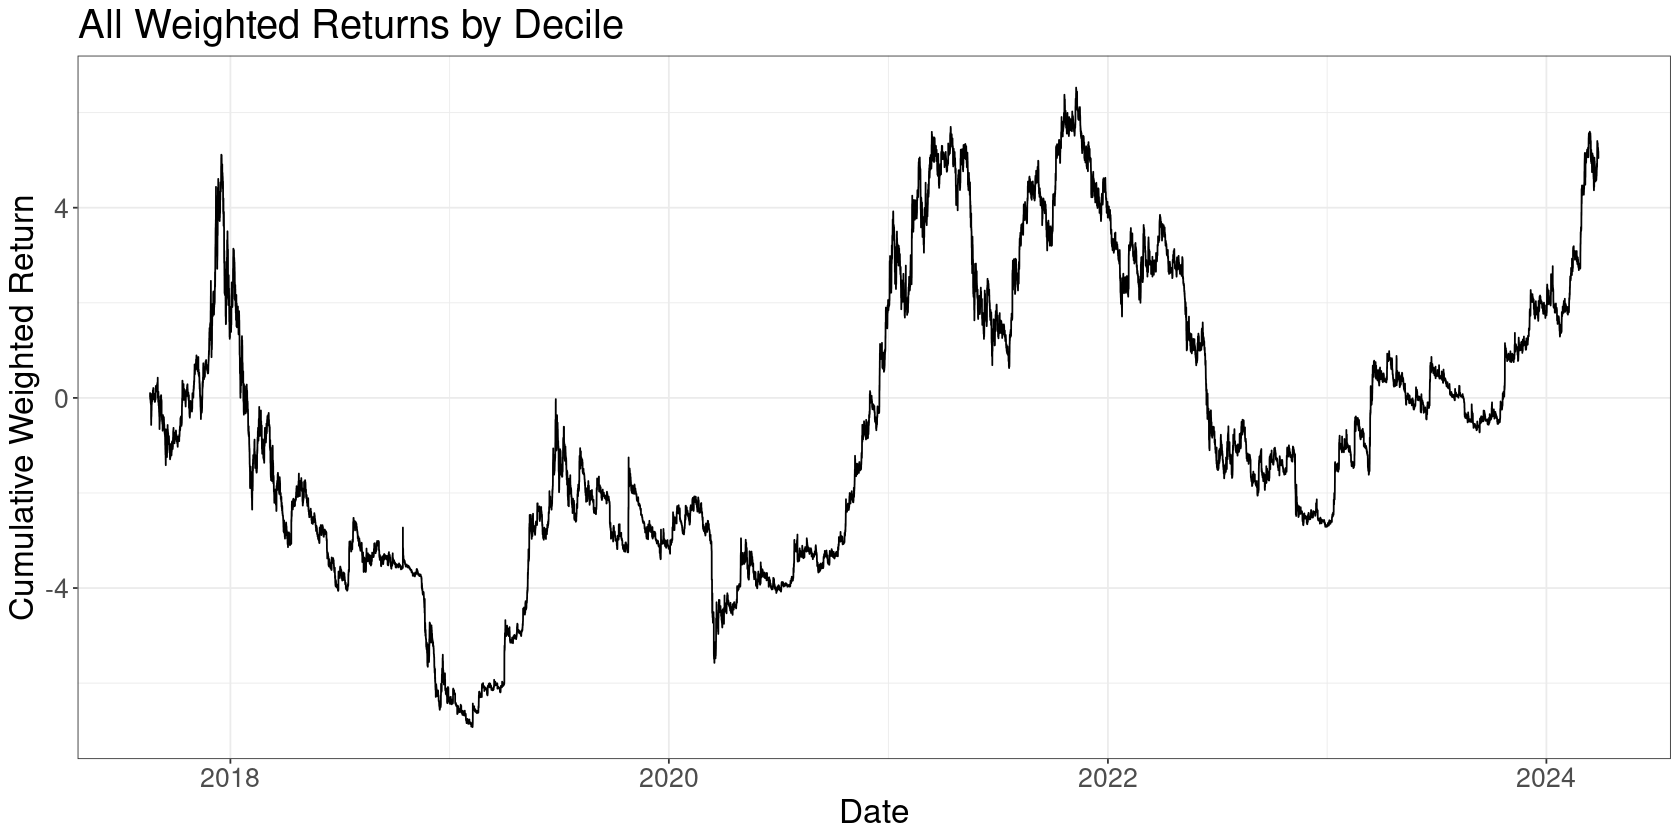

In [53]:
# Create a new data frame with weighted returns for each feature.
weighted_returns <- features_scaled %>%
  mutate(
    # Apply weights only if the absolute decile value is greater than 3
    weighted_return_momo = ifelse(abs(momo_decile) > 3, future_log_return * momo_decile, 0),
    weighted_return_delta = ifelse(abs(delta_decile) > 3, future_log_return * delta_decile, 0),
    weighted_return_rate = ifelse(abs(rate_decile) > 3, future_log_return * rate_decile, 0),
    # # log
    # weighted_return_momo = future_log_return * momo_decile,
    # weighted_return_delta = future_log_return * delta_decile,
    # weighted_return_rate = future_log_return * rate_decile,
    # # simple
    # weighted_return_momo = future_return * momo_decile,
    # weighted_return_delta = future_return * delta_decile,
    # weighted_return_rate = future_return * rate_decile,
    #
    weighted_return_sum = (weighted_return_momo+ weighted_return_delta+ weighted_return_rate)/3,
  )

# Plot the cumulative weighted returns for each feature in separate tiles.
weighted_returns %>%
  select(datetime, weighted_return_momo, weighted_return_delta, weighted_return_rate) %>%
  pivot_longer(
    cols = starts_with("weighted_return"),
    names_to = "feature",
    values_to = "weighted_return"
  ) %>%
  group_by(feature) %>%
  mutate(cum_weighted_return = cumsum(weighted_return)) %>%
  ungroup() %>%
  ggplot(aes(x = datetime, y = cum_weighted_return)) +
    geom_line() +
    facet_wrap(~ feature, scales = "free_y", ncol = 1) + # Adjust 'ncol' as needed for layout
    labs(
      title = "Cumulative Weighted Returns by Decile",
      x = "Date",
      y = "Cumulative Weighted Return"
    )

weighted_returns %>%
ggplot(aes(x = datetime, y = cumsum(weighted_return_sum))) +
  geom_line() +
  labs(
    title = "All Weighted Returns by Decile",
    x = "Date",
    y = "Cumulative Weighted Return"
  )